# SVC Model

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (15, 15)

## Retrieve all of the features and labels

In [4]:
npzfile = np.load('../data/melspects.npz', allow_pickle=True)

In [5]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

## Normalize the Data

We need to reshape the data so that we can use sklearn's `StandardScaler` becasue it only works with 2D arrays. Our data is currently stored as a 3D array.

In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## PCA

So currently we have 61440 features, I'm going to use PCA to reduce the dimensionality significantly. I decided to keep 95% of the variance. This resulted in a model with 526 features.

In [8]:
X_train_sc.shape

(750, 61440)

In [45]:
pca = PCA(n_components=0.95)
pca.fit(X_train_sc)

X_train_reduced = pca.transform(X_train_sc)
X_test_reduced = pca.transform(X_test_sc)

In [46]:
X_train_reduced.shape

(750, 526)

## Training the Model

I'm going to be using the rbf kernel, which will make it slower to train, but guarantees separation.  

I'm going to perform crossvalidation for hyperparamter tunning on the $C$ parameter.

In [47]:
parameters = {'C': np.arange(0.5, 3.0, 0.1)}

svc = SVC(kernel='rbf')

clf = GridSearchCV(svc, parameters)

In [48]:
clf.fit(X_train_reduced, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 2.8999999999999995}

Grid scores on development set:

0.428 (+/-0.067) for {'C': 0.5}
0.444 (+/-0.052) for {'C': 0.6}
0.475 (+/-0.073) for {'C': 0.7}
0.491 (+/-0.085) for {'C': 0.7999999999999999}
0.503 (+/-0.075) for {'C': 0.8999999999999999}
0.507 (+/-0.066) for {'C': 0.9999999999999999}
0.511 (+/-0.068) for {'C': 1.0999999999999999}
0.515 (+/-0.066) for {'C': 1.1999999999999997}
0.513 (+/-0.065) for {'C': 1.2999999999999998}
0.515 (+/-0.068) for {'C': 1.4}
0.521 (+/-0.073) for {'C': 1.4999999999999998}
0.523 (+/-0.072) for {'C': 1.5999999999999996}
0.524 (+/-0.075) for {'C': 1.6999999999999997}
0.529 (+/-0.072) for {'C': 1.7999999999999998}
0.531 (+/-0.068) for {'C': 1.8999999999999997}
0.533 (+/-0.072) for {'C': 1.9999999999999996}
0.537 (+/-0.078) for {'C': 2.0999999999999996}
0.536 (+/-0.080) for {'C': 2.1999999999999997}
0.536 (+/-0.080) for {'C': 2.3}
0.536 (+/-0.082) for {'C': 2.3999999999999995}
0.536 (+/-0.082) for {'C': 2

Again rock and disco seem to be the hardest genres to classify. The accuracy of our model is at 51%, this is a fairly significant improvement over the KNN model. The best $C$ value turned out to be $2.9$. Metal and Pop are again the easiest to classify, but this time are model was able to accurately classify classical music as well.

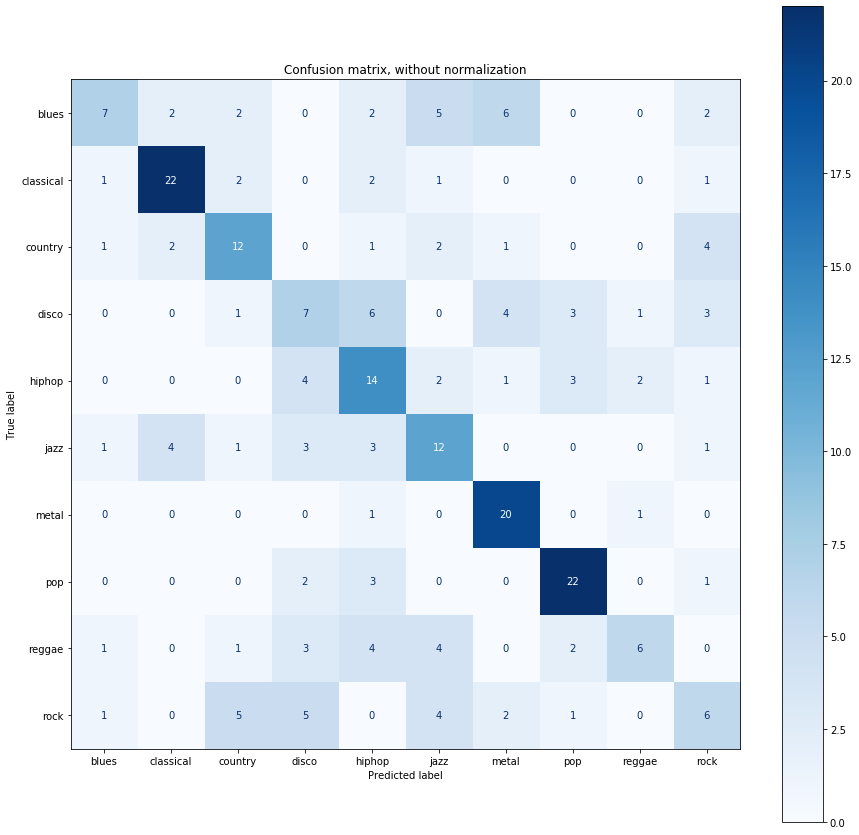

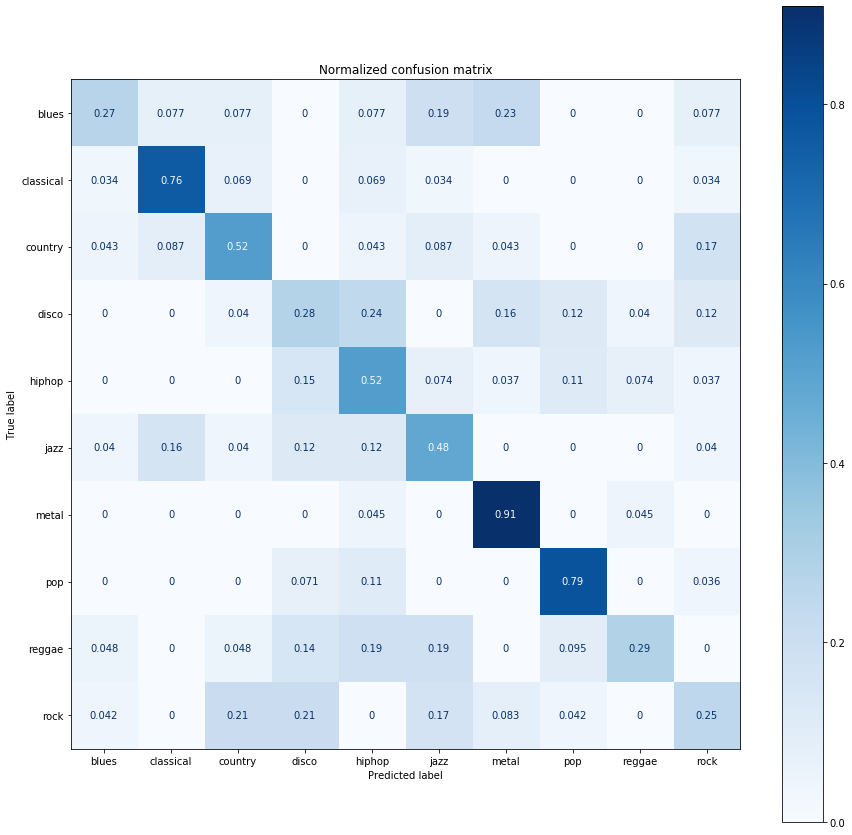

In [51]:
class_names = ['blues', 'classical', 'country', 'disco', 
               'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test_reduced, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()